In [1]:
options(repr.plot.width=12)

library(tidyverse)
suppressMessages(library(here))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
load(file = here('data', 'covid_tracking.rda'))
load(file = here('data', 'us_states.rda'))

In [3]:
tbl_historical <- tbl_historical %>% 
  left_join(tbl_state, by = c('state' = 'state_postal'))

tbl_historical %>% head()

date,state,positive,negative,pending,hospitalized_currently,hospitalized_cumulative,in_icu_currently,in_icu_cumulative,on_ventilator_currently,⋯,pos_neg,fips,death_increase,hospitalized_increase,negative_increase,positive_increase,total_test_results_increase,region,division,state_name
<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
2020-03-06,AK,0,8,1,NA,NA,NA,NA,NA,⋯,8,02,NA,NA,NA,NA,NA,West,Pacific,Alaska
2020-03-07,AK,0,12,2,NA,NA,NA,NA,NA,⋯,12,02,0,0,4,0,4,West,Pacific,Alaska
2020-03-08,AK,0,14,6,NA,NA,NA,NA,NA,⋯,14,02,0,0,2,0,2,West,Pacific,Alaska
2020-03-09,AK,0,23,9,NA,NA,NA,NA,NA,⋯,23,02,0,0,9,0,9,West,Pacific,Alaska
2020-03-10,AK,0,23,9,NA,NA,NA,NA,NA,⋯,23,02,0,0,0,0,0,West,Pacific,Alaska
2020-03-11,AK,0,46,14,NA,NA,NA,NA,NA,⋯,46,02,0,0,23,0,23,West,Pacific,Alaska


In [4]:
tbl_historical %>% select(-hash) %>% str()

tibble [4,105 × 29] (S3: tbl_df/tbl/data.frame)
 $ date                       : Date[1:4105], format: "2020-03-06" "2020-03-07" ...
 $ state                      : chr [1:4105] "AK" "AK" "AK" "AK" ...
 $ positive                   : num [1:4105] 0 0 0 0 0 0 0 1 1 1 ...
 $ negative                   : num [1:4105] 8 12 14 23 23 46 46 59 143 143 ...
 $ pending                    : num [1:4105] 1 2 6 9 9 14 14 NA NA NA ...
 $ hospitalized_currently     : num [1:4105] NA NA NA NA NA NA NA NA NA NA ...
 $ hospitalized_cumulative    : num [1:4105] NA NA NA NA NA NA NA NA NA NA ...
 $ in_icu_currently           : num [1:4105] NA NA NA NA NA NA NA NA NA NA ...
 $ in_icu_cumulative          : num [1:4105] NA NA NA NA NA NA NA NA NA NA ...
 $ on_ventilator_currently    : num [1:4105] NA NA NA NA NA NA NA NA NA NA ...
 $ on_ventilator_cumulative   : num [1:4105] NA NA NA NA NA NA NA NA NA NA ...
 $ recovered                  : num [1:4105] NA NA NA NA NA NA NA NA NA NA ...
 $ data_quality_grade  

The table `tbl_labels` will allow us to place a marker at the end of time series.

In [5]:
tbl_labels <- tbl_historical %>% 
  group_by(state) %>% 
  arrange(desc(date), .by_group = TRUE) %>% 
  slice(1)

The two cells below will let us sort the states by either positive reported cases or deaths.

In [6]:
state_by_positive <- tbl_historical %>% 
  group_by(state) %>% 
  summarise(max_cumul = max(positive, na.rm = TRUE)) %>% 
  ungroup() %>% 
  arrange(desc(max_cumul)) %>% 
  pull(state)

state_by_positive %>% head()

[1] "NY" "NJ" "IL" "MA" "CA" "PA"

In [7]:
state_by_death <- tbl_historical %>% 
  group_by(state) %>% 
  summarise(max_cumul = max(death, na.rm = TRUE)) %>% 
  ungroup() %>% 
  arrange(desc(max_cumul)) %>% 
  pull(state)

state_by_death %>% head()

[1] "NY" "NJ" "MA" "MI" "PA" "IL"

Here, we're applying the factor orders that we developed above. We can switch this to deaths, if we want. Just put something similar (sans the `factor(state)` call) in front of a call to `ggplot()`.

In [8]:
tbl_historical <- tbl_historical %>%
  mutate(
      state = factor(state)
      , state = fct_relevel(state, state_by_positive)
  )

The display below is a bit of a mess.

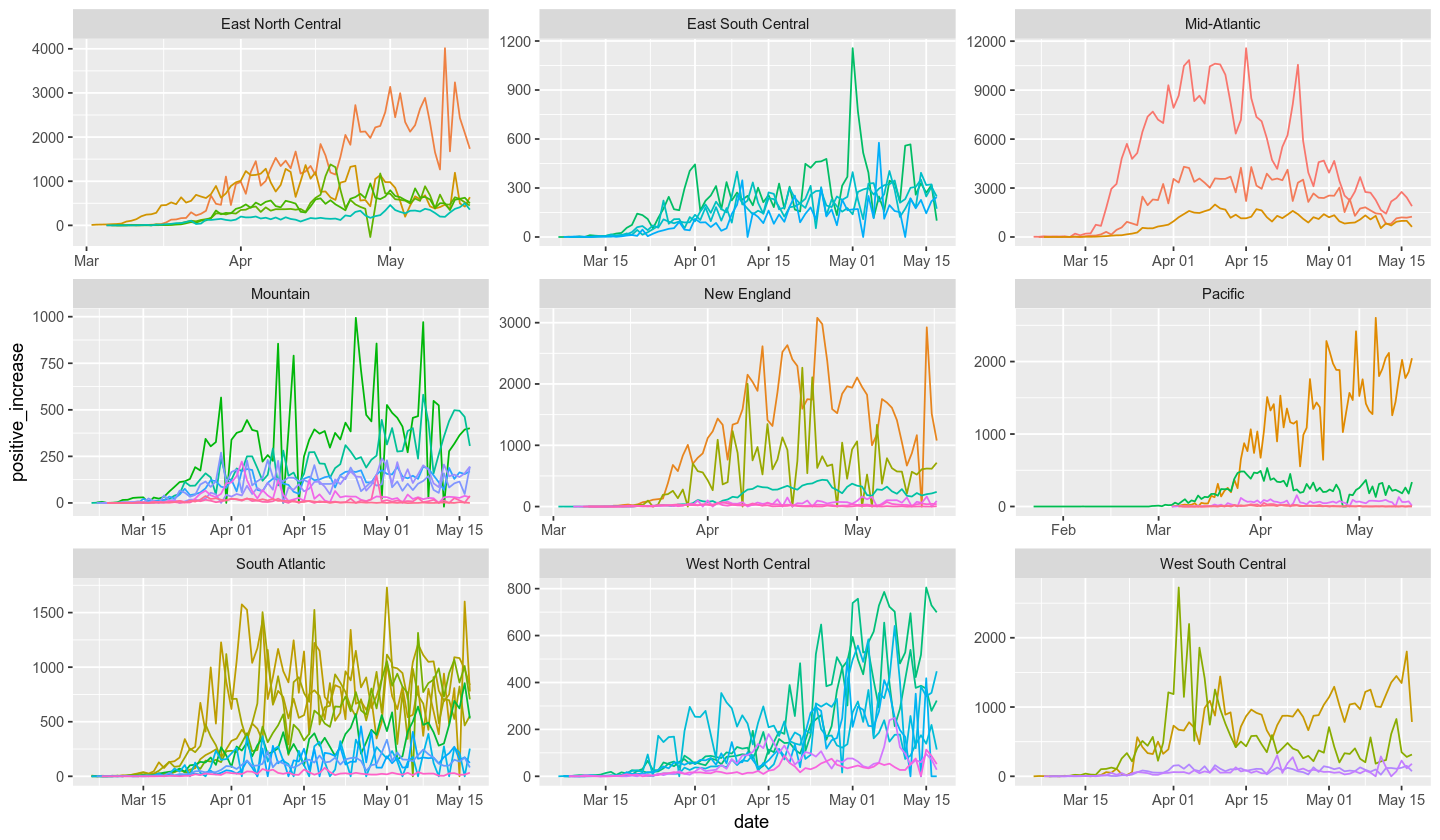

In [9]:
tbl_historical %>% 
  filter(division != 'Territories') %>% 
  filter(!is.na(positive_increase)) %>% 
  ggplot(aes(date, positive_increase)) + 
  geom_line(aes(color = state), show.legend = FALSE) + 
  facet_wrap(~division, scales = 'free')

This one will give us every state. A bit cleaner, but still too busy.

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



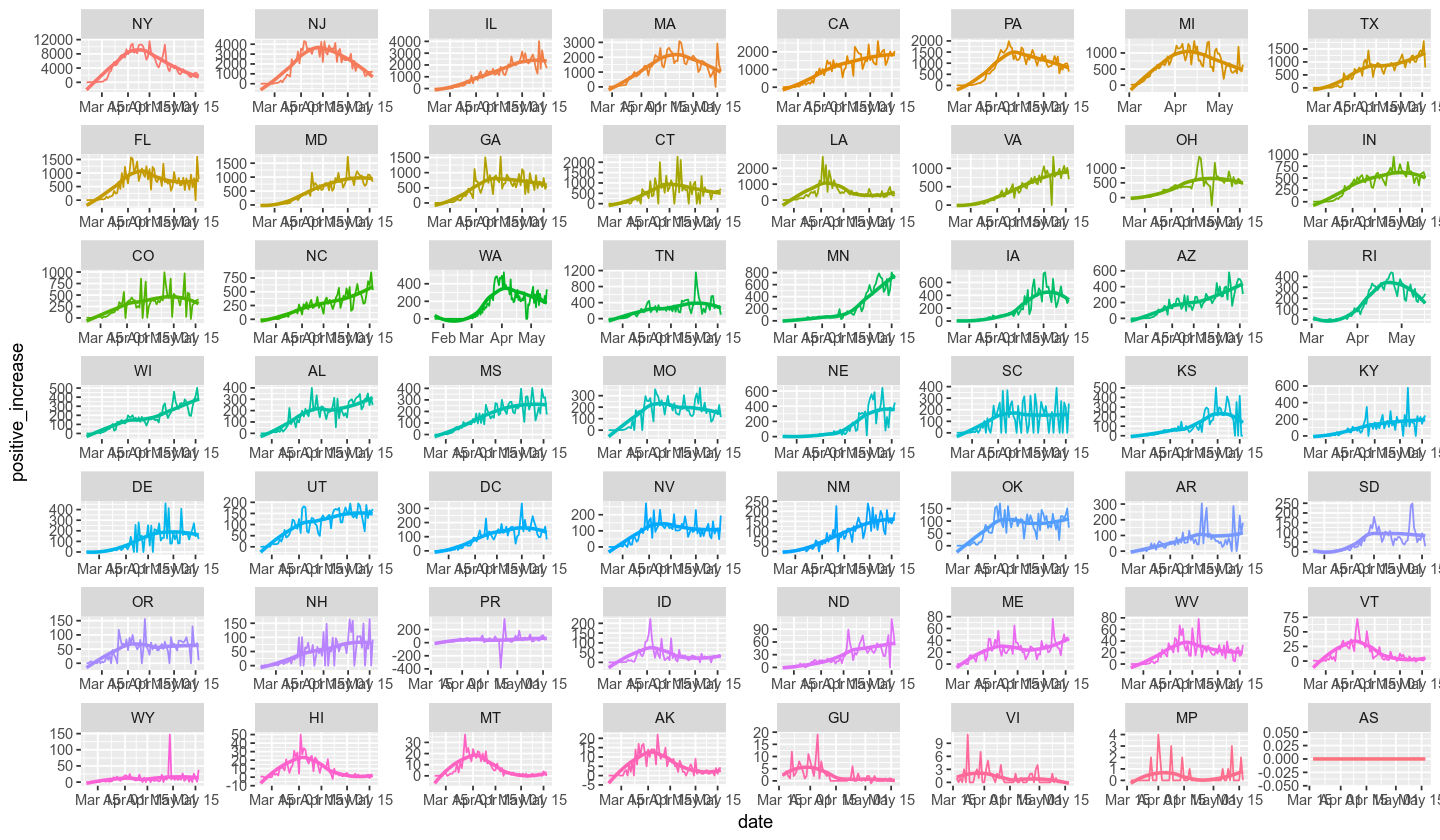

In [10]:
tbl_historical %>% 
  filter(!is.na(positive_increase)) %>% 
  ggplot(aes(date, positive_increase)) + 
  geom_line(aes(color = state), show.legend = FALSE) + 
  geom_smooth(aes(color = state), show.legend = FALSE, se = FALSE) + 
  facet_wrap(~state, scales = 'free') + 
  NULL

Below, we can focus on the top five or six states. Reversals for most, but not all

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



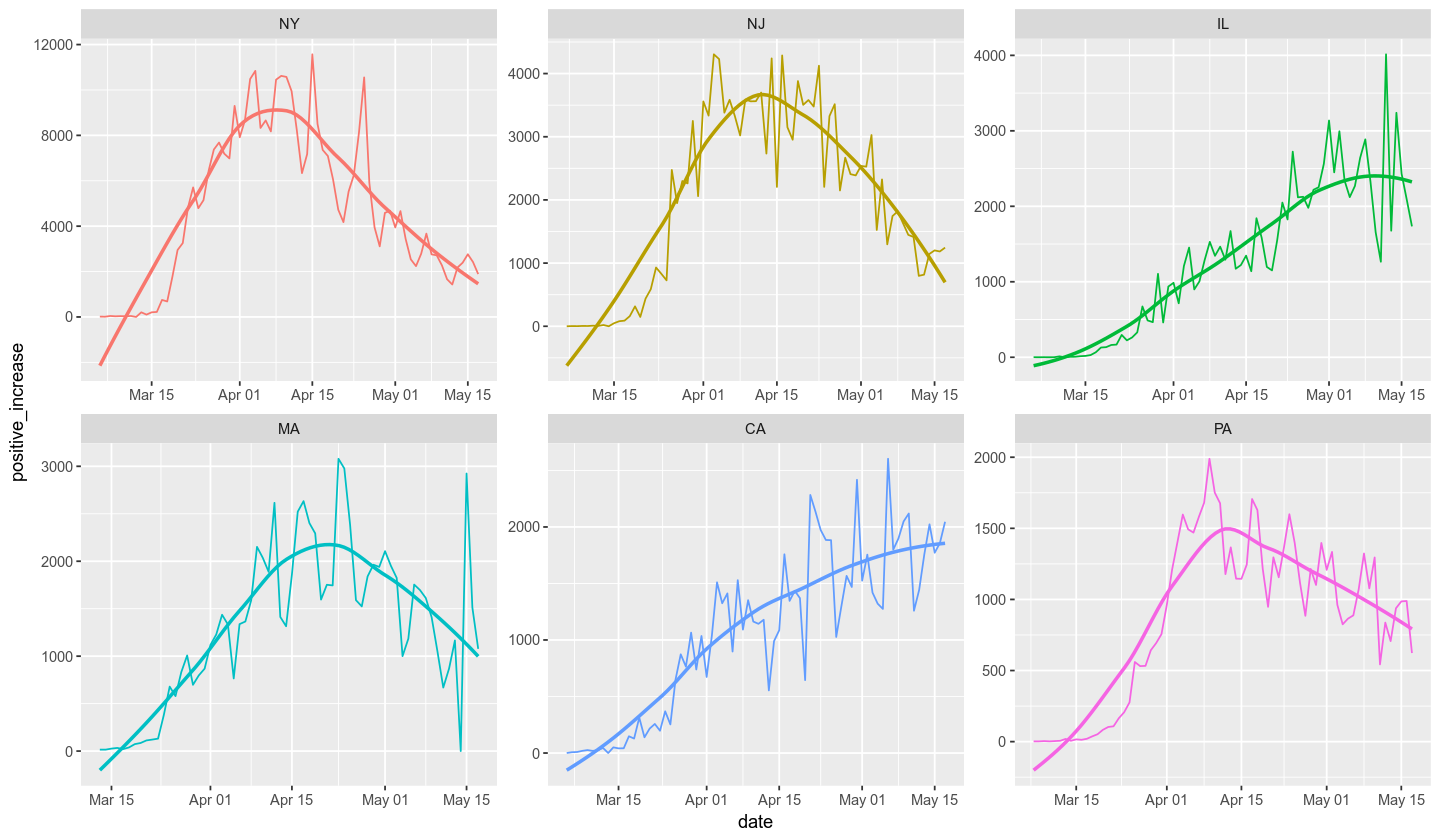

In [11]:
tbl_historical %>% 
  filter(!is.na(positive_increase)) %>% 
  filter(state %in% state_by_positive[1:6]) %>% 
  ggplot(aes(date, positive_increase)) + 
  geom_line(aes(color = state), show.legend = FALSE) + 
  geom_smooth(aes(color = state), show.legend = FALSE, se = FALSE) + 
  facet_wrap(~state, scales = 'free') + 
  NULL

Looking at the next set of six may give us an idea of potential next hotspots

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



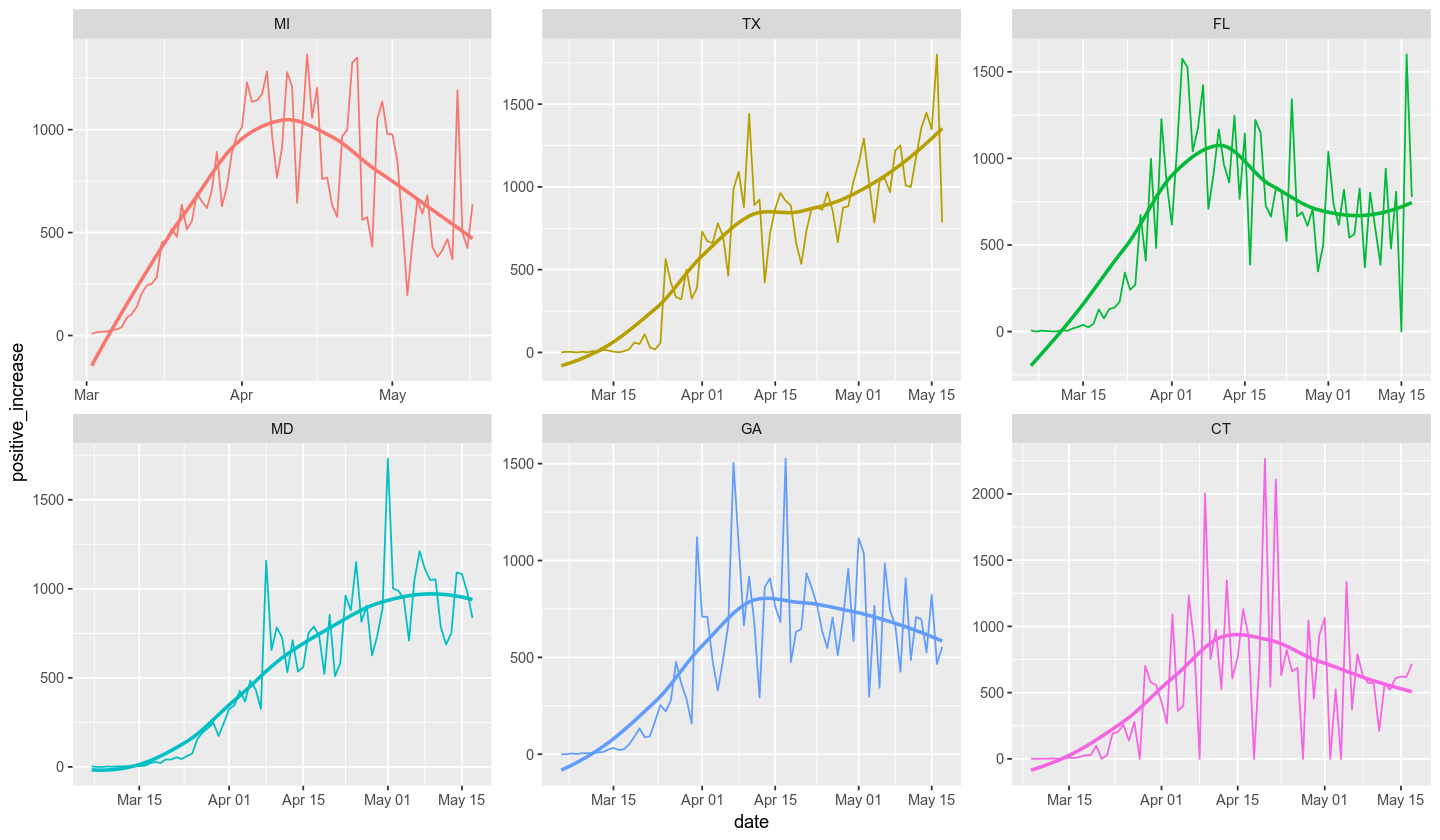

In [12]:
tbl_historical %>% 
  filter(!is.na(positive_increase)) %>% 
  filter(state %in% state_by_positive[7:12]) %>% 
  ggplot(aes(date, positive_increase)) + 
  geom_line(aes(color = state), show.legend = FALSE) + 
  geom_smooth(aes(color = state), show.legend = FALSE, se = FALSE) + 
  facet_wrap(~state, scales = 'free') + 
  NULL

And we can do the same for deaths. There are very clear reporting issues: a few spikes - both positive and negative - and autocorrelation. The latter is likely due to processing issues that mean a lag in entering data, which is reversed on a subsequent day.

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



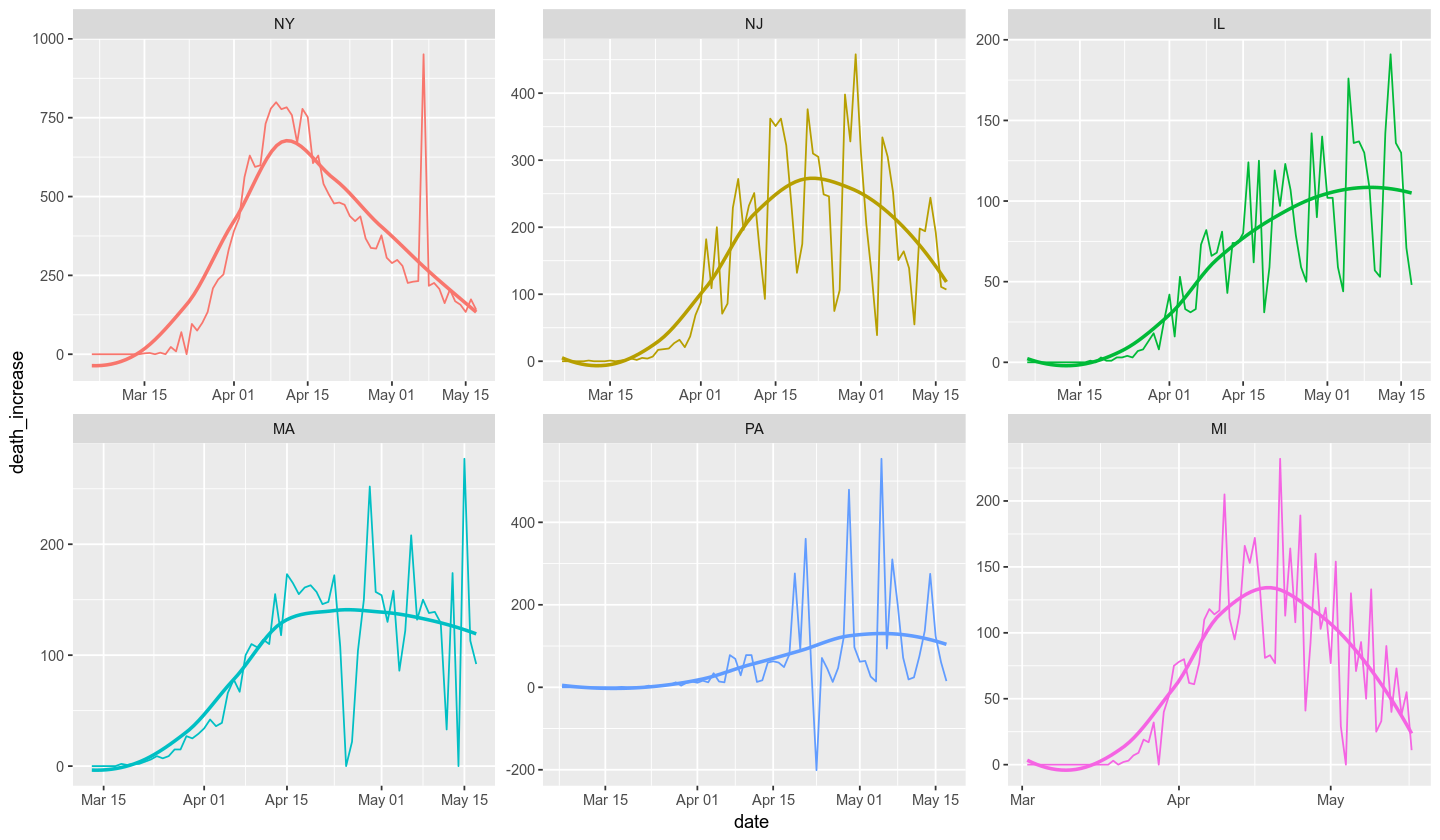

In [13]:
tbl_historical %>% 
  filter(!is.na(death_increase)) %>% 
  filter(state %in% state_by_death[1:6]) %>% 
  ggplot(aes(date, death_increase)) + 
  geom_line(aes(color = state), show.legend = FALSE) + 
  geom_smooth(aes(color = state), show.legend = FALSE, se = FALSE) + 
  facet_wrap(~state, scales = 'free') + 
  NULL

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



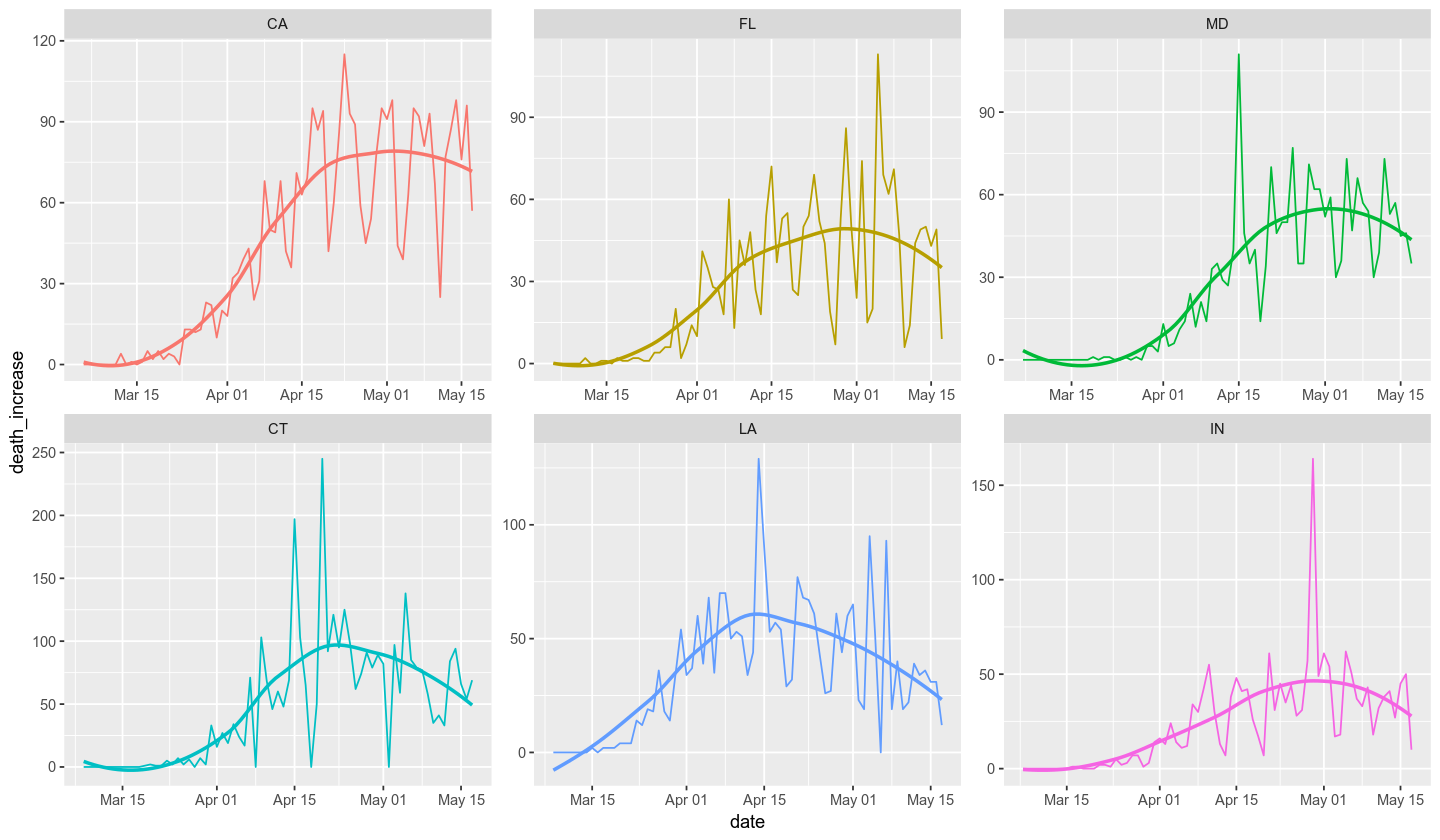

In [14]:
tbl_historical %>% 
  filter(!is.na(death_increase)) %>% 
  filter(state %in% state_by_death[7:12]) %>% 
  ggplot(aes(date, death_increase)) + 
  geom_line(aes(color = state), show.legend = FALSE) + 
  geom_smooth(aes(color = state), show.legend = FALSE, se = FALSE) + 
  facet_wrap(~state, scales = 'free') + 
  NULL